In [3]:
import os
import json
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile

import warnings
warnings.simplefilter("ignore", UserWarning)

import pickle
from tqdm import tqdm
import scipy
import sys

In [4]:
kaggle_cred = json.load(open("/content/kaggle (1).json"))

os.environ['KAGGLE_USERNAME'] = kaggle_cred["username"]
os.environ['KAGGLE_KEY'] = kaggle_cred["key"]

In [5]:
!kaggle datasets download -d andradaolteanu/gtzan-dataset-music-genre-classification

Dataset URL: https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification
License(s): other
 98% 1.19G/1.21G [00:15<00:00, 139MB/s]
100% 1.21G/1.21G [00:15<00:00, 82.6MB/s]


In [6]:
!ls

 gtzan-dataset-music-genre-classification.zip  'kaggle (1).json'   sample_data


In [7]:
with ZipFile("gtzan-dataset-music-genre-classification.zip" ,"r") as zip_ref:
  zip_ref.extractall()

In [8]:
!ls Data

features_30_sec.csv  features_3_sec.csv  genres_original  images_original


In [9]:
import  librosa
import librosa.display as ld

In [48]:
import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout


from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score,confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.decomposition import PCA

from xgboost import XGBClassifier

A collection of 10 genres with 100 audio files each, all having a length of 30 seconds (the famous GTZAN dataset, the MNIST of sounds)

In [11]:
df = pd.read_csv("/content/Data/features_3_sec.csv")

In [12]:
df.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [13]:
df.shape

(9990, 60)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9990 entries, 0 to 9989
Data columns (total 60 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   filename                 9990 non-null   object 
 1   length                   9990 non-null   int64  
 2   chroma_stft_mean         9990 non-null   float64
 3   chroma_stft_var          9990 non-null   float64
 4   rms_mean                 9990 non-null   float64
 5   rms_var                  9990 non-null   float64
 6   spectral_centroid_mean   9990 non-null   float64
 7   spectral_centroid_var    9990 non-null   float64
 8   spectral_bandwidth_mean  9990 non-null   float64
 9   spectral_bandwidth_var   9990 non-null   float64
 10  rolloff_mean             9990 non-null   float64
 11  rolloff_var              9990 non-null   float64
 12  zero_crossing_rate_mean  9990 non-null   float64
 13  zero_crossing_rate_var   9990 non-null   float64
 14  harmony_mean            

In [15]:
df = df.drop(labels = "filename", axis=1)

**Exploring** audio stats

In [16]:
audio = "/content/Data/genres_original/blues/blues.00003.wav"

data, sr = librosa.load(audio)
print("data type: " ,type(data))
print("sample rate type: ",type(sr))
print("data", data)
print("Data Shape:",np.shape(data))
print("Samlpe rate:", sr)
print("size", np.shape(data)[0]/sr)

data type:  <class 'numpy.ndarray'>
sample rate type:  <class 'int'>
data [-0.01300049 -0.03060913 -0.03607178 ...  0.0098877   0.01107788
  0.0118103 ]
Data Shape: (661794,)
Samlpe rate: 22050
size 30.013333333333332


In [17]:
librosa.load(audio, sr =22050)

(array([-0.01300049, -0.03060913, -0.03607178, ...,  0.0098877 ,
         0.01107788,  0.0118103 ], dtype=float32),
 22050)

In [18]:
import IPython
from IPython.display import Audio

In [19]:
IPython.display.Audio(data, rate=sr)

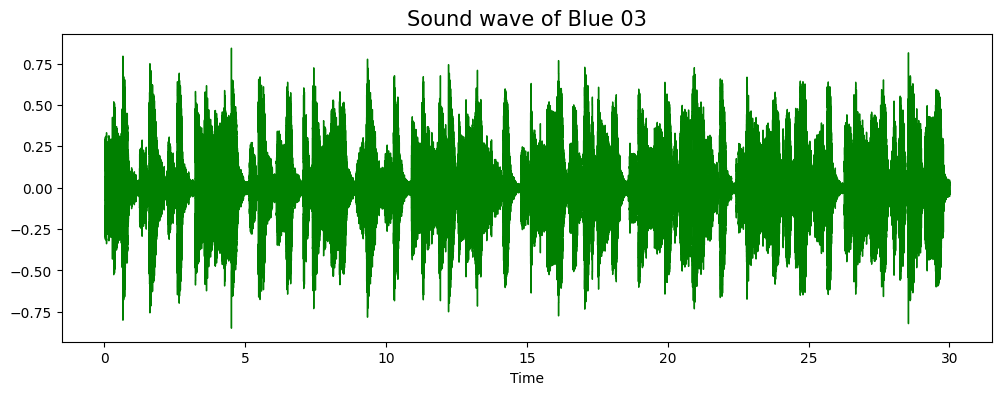

In [20]:
plt.figure(figsize = (12,4))
librosa.display.waveshow(data, color = "green")
plt.title("Sound wave of Blue 03" ,fontsize=15)
plt.show()

In [23]:
# Default FFT window size
n_fft = 2048 # FFT window size
hop_length = 512 # number audio of frames between STFT columns

**One way to classify data is through neural networks of visual representation for each audio file, usually take in some sort of image representation, the audio files were converted to Mel Spectrograms to make this possible**

---

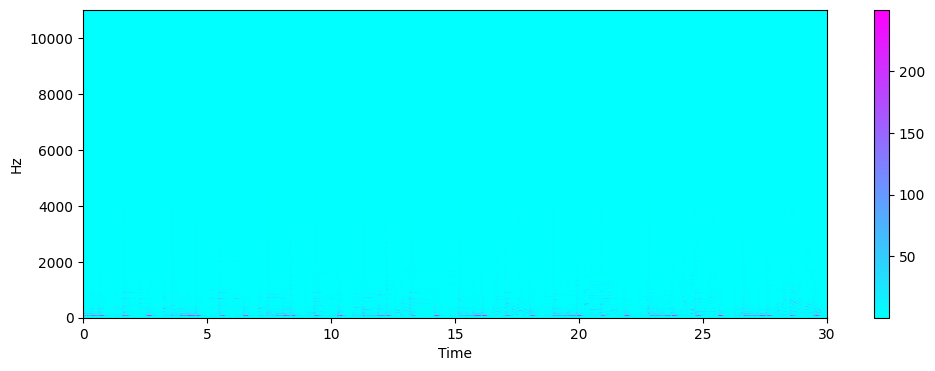

In [24]:
spect = librosa.stft(data)
spect_db = librosa.amplitude_to_db(abs(spect))
plt.figure(figsize = (12,4))
librosa.display.specshow(spect, sr=sr,
                         hop_length = hop_length,
                         x_axis="time",
                         y_axis = "hz",
                         cmap = "cool")
plt.colorbar()
plt.show()

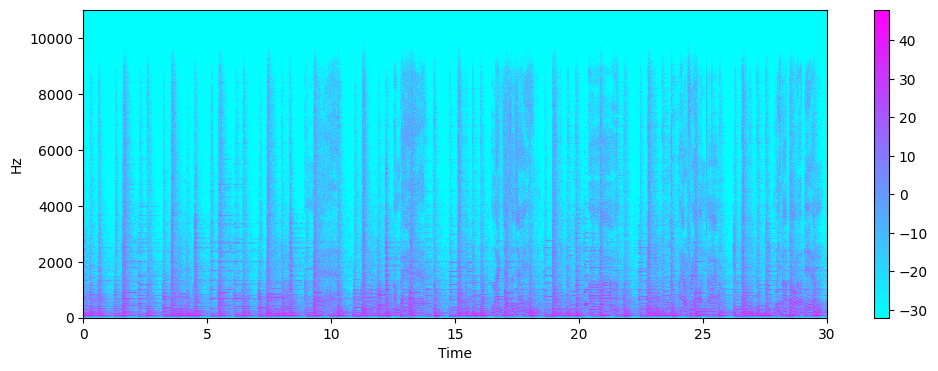

In [25]:
spect = librosa.stft(data)
spect_db = librosa.amplitude_to_db(abs(spect))
plt.figure(figsize = (12,4))
librosa.display.specshow(spect_db, sr=sr,
                         hop_length = hop_length,
                         x_axis="time",
                         y_axis = "hz",
                         cmap = "cool")
plt.colorbar()
plt.show()

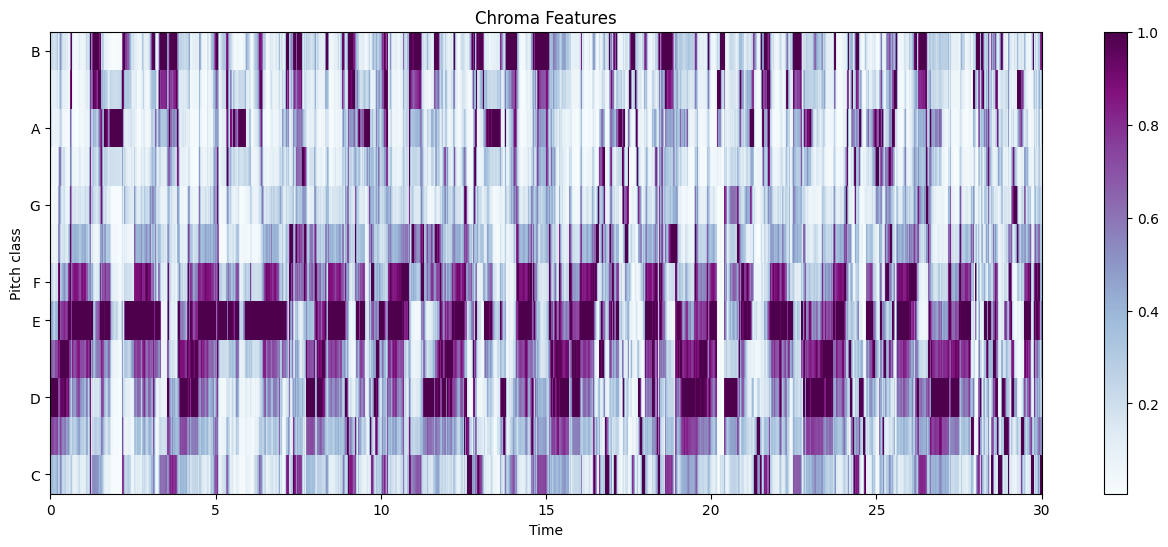

In [22]:
chroma = librosa.feature.chroma_stft(y=data, sr=sr)

# Plot the chroma features
plt.figure(figsize=(16, 6))
ld.specshow(chroma, sr=sr, x_axis='time', y_axis='chroma', cmap='BuPu')
plt.colorbar()
plt.title("Chroma Features")
plt.show()

**Scaling**

In [26]:
df.sample(5)

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
5723,66149,0.333207,0.085921,0.127144,0.001992,2910.772944,172192.187485,2886.776758,146827.670620,6272.787710,...,49.931652,-6.797010,23.957325,-3.361657,58.871017,2.776204,70.690529,1.023353,113.577980,jazz
6425,66149,0.421397,0.087496,0.093933,0.001079,2508.380104,354256.660247,1944.414019,130600.545227,4457.704327,...,60.191547,-7.778222,105.128258,6.207757,55.488258,-8.268727,74.017799,1.848549,74.954796,metal
4340,66149,0.448746,0.085939,0.199075,0.002366,3313.096482,143963.205323,2736.050477,30127.278364,6634.711163,...,40.940758,-1.982800,32.784294,3.240949,33.061867,-1.959400,20.848381,1.633973,73.610283,hiphop
404,66149,0.385571,0.082273,0.140383,0.000779,2275.458183,125719.677974,2242.862381,29059.927990,4838.345102,...,27.251076,-6.856206,29.087656,-6.999356,29.371861,-6.236311,36.071373,2.733410,47.828033,blues
6831,66149,0.445353,0.082385,0.221695,0.000982,2360.203507,344788.356310,2210.351347,89337.456030,4840.829703,...,16.183510,-11.440867,20.642939,5.811172,16.649599,-7.901381,20.019817,-8.170116,33.575932,metal


In [27]:
y = df.iloc[:, -1]

In [28]:
enc = LabelEncoder()
y = enc.fit_transform(y)

In [29]:
y

array([0, 0, 0, ..., 9, 9, 9])

In [30]:
df.head()

,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,3714.560359,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,3869.682242,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,3997.639160,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,3568.300218,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,3469.992864,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [31]:
print(np.array(df.iloc[:, :-1]))

[[ 6.61490000e+04  3.35406363e-01  9.10482928e-02 ...  3.36180725e+01
  -2.43026793e-01  4.37717667e+01]
 [ 6.61490000e+04  3.43065351e-01  8.61465260e-02 ...  9.70308304e+01
   5.78406334e+00  5.99430809e+01]
 [ 6.61490000e+04  3.46814752e-01  9.22428891e-02 ...  5.30508347e+01
   2.51737475e+00  3.31051216e+01]
 ...
 [ 6.61490000e+04  3.47480893e-01  8.90194401e-02 ...  4.85823784e+01
  -2.99545288e-01  4.15869904e+01]
 [ 6.61490000e+04  3.87527317e-01  8.48154277e-02 ...  2.48436127e+01
   6.75824106e-01  1.27877502e+01]
 [ 6.61490000e+04  3.69292945e-01  8.67586955e-02 ...  3.94859009e+01
  -3.41253424e+00  3.17274895e+01]]


In [32]:
scale = StandardScaler()
X = scale.fit_transform(np.array(df.iloc[:, :-1], dtype = float))

In [33]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 41)

In [34]:
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier, XGBRFClassifier
from xgboost import plot_tree, plot_importance

In [35]:
def model_start(model, title = "Default"):
  model.fit(X_train, y_train)
  pred = model.predict(X_test)
  # print(confusion_matrix(y_test, pred))
  print("Accuracy", title, "-->", round(accuracy_score(y_test,pred),5),'\n')

In [36]:
# Naive Bayes
nb = GaussianNB()
model_start(nb, "Naive Bayes")

# Stochastic Gradient Descent
sgd = SGDClassifier(max_iter=5000, random_state=0)
model_start(sgd, "Stochastic Gradient Descent")

# KNN
knn = KNeighborsClassifier(n_neighbors=19)
model_start(knn, "KNN")

# Decission trees
tree = DecisionTreeClassifier()
model_start(tree, "Decission trees")

# Random Forest
rforest = RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0)
model_start(rforest, "Random Forest")

# Support Vector Machine
svm = SVC(decision_function_shape="ovo")
model_start(svm, "Support Vector Machine")

# Logistic Regression
lg = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial')
model_start(lg, "Logistic Regression")

# Neural Nets
nn = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1)
model_start(nn, "Neural Nets")

# Cross Gradient Booster
xgb = XGBClassifier(n_estimators=1000, learning_rate=0.05)
model_start(xgb, "Cross Gradient Booster")

# Cross Gradient Booster (Random Forest)
xgbrf = XGBRFClassifier(objective= 'multi:softmax')
model_start(xgbrf, "Cross Gradient Booster (Random Forest)")

Accuracy Naive Bayes --> 0.52352 

Accuracy Stochastic Gradient Descent --> 0.64615 

Accuracy KNN --> 0.81632 

Accuracy Decission trees --> 0.64815 

Accuracy Random Forest --> 0.80581 

Accuracy Support Vector Machine --> 0.85035 

Accuracy Logistic Regression --> 0.71722 

Accuracy Neural Nets --> 0.88739 

Accuracy Cross Gradient Booster --> 0.90841 

Accuracy Cross Gradient Booster (Random Forest) --> 0.75325 



In [37]:
model = XGBClassifier( n_estimators = 1000, learning_rate = 0.05)
model.fit(X_train,y_train, eval_metric = 'merror')

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

Accuracy: 0.90841 



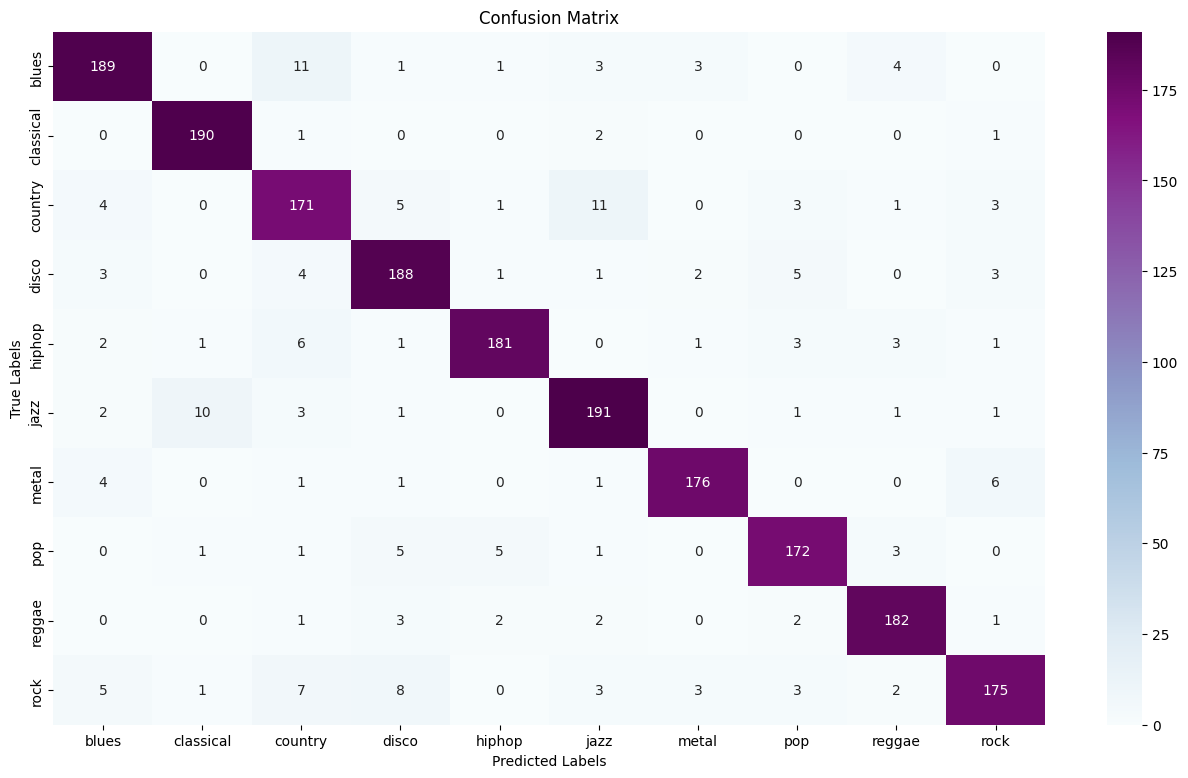

Testing:
              precision    recall  f1-score   support

       blues       0.90      0.89      0.90       212
   classical       0.94      0.98      0.96       194
     country       0.83      0.86      0.84       199
       disco       0.88      0.91      0.90       207
      hiphop       0.95      0.91      0.93       199
        jazz       0.89      0.91      0.90       210
       metal       0.95      0.93      0.94       189
         pop       0.91      0.91      0.91       188
      reggae       0.93      0.94      0.94       193
        rock       0.92      0.85      0.88       207

    accuracy                           0.91      1998
   macro avg       0.91      0.91      0.91      1998
weighted avg       0.91      0.91      0.91      1998



In [46]:
# Assuming the model and data are already prepared
pred = model.predict(X_test)

# Calculate accuracy
print('Accuracy:', round(accuracy_score(y_test, pred), 5), '\n')

# Compute confusion matrix with integer-encoded labels
confusion_matr = confusion_matrix(y_test, pred)

# Original class names
labels = ["blues", "classical", "country", "disco", "hiphop", "jazz", "metal", "pop", "reggae", "rock"]

# Convert confusion matrix to DataFrame for better visualization
confusion_df = pd.DataFrame(confusion_matr, index=labels, columns=labels)

# Plot confusion matrix
plt.figure(figsize=(16, 9))
sns.heatmap(confusion_df, annot=True, fmt='d', cmap='BuPu')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate classification report with integer labels
report = classification_report(y_test, pred, target_names=labels)
print(f'Testing:\n{report}')

**CNN method**

In [49]:
model = Sequential()

model.add(Dense(512,activation = "relu", input_shape = (X_train.shape[1],)))
model.add(Dropout(0.3))

model.add(Dense(256,activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(128,activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(64,activation = "relu"))
model.add(Dropout(0.3))

model.add(Dense(10,activation = "softmax"))

In [50]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               30208     
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 64)                8

In [54]:
def trainModel(model, epochs, optimizer):
  batch_size = 128
  model.compile(optimizer = optimizer,
                loss = 'sparse_categorical_crossentropy',
                metrics = 'accuracy')
  return model.fit(X_train, y_train,
                   validation_data = (X_test, y_test),
                   epochs = epochs,
                   batch_size = batch_size)

In [52]:
def plotcurve(history):
  print("Validation_accuracy", max(history.history['val_accuracy']))
  pd.DataFrame(history.history).plot(figsize = (12,6))
  plt.show()

In [57]:
history = trainModel(model= model,
                     epochs = 1000,
                     optimizer = "adam")

Epoch 1/1000
63/63 [==============================] - 2s 8ms/step - loss: 1.1667 - accuracy: 0.6902 - val_loss: 1.2495 - val_accuracy: 0.9049
Epoch 2/1000
63/63 [==============================] - 0s 5ms/step - loss: 1.1869 - accuracy: 0.6887 - val_loss: 1.2383 - val_accuracy: 0.9089
Epoch 3/1000
63/63 [==============================] - 0s 5ms/step - loss: 1.2304 - accuracy: 0.6848 - val_loss: 1.2286 - val_accuracy: 0.9044
Epoch 4/1000
63/63 [==============================] - 0s 5ms/step - loss: 1.2680 - accuracy: 0.6767 - val_loss: 1.2123 - val_accuracy: 0.9119
Epoch 5/1000
63/63 [==============================] - 0s 5ms/step - loss: 1.2111 - accuracy: 0.6887 - val_loss: 1.1732 - val_accuracy: 0.9119
Epoch 6/1000
63/63 [==============================] - 0s 5ms/step - loss: 1.2308 - accuracy: 0.6888 - val_loss: 1.1855 - val_accuracy: 0.9139
Epoch 7/1000
63/63 [==============================] - 0s 5ms/step - loss: 1.1970 - accuracy: 0.6909 - val_loss: 1.2741 - val_accuracy: 0.9014
Epoch 

Validation_accuracy 0.9349349141120911


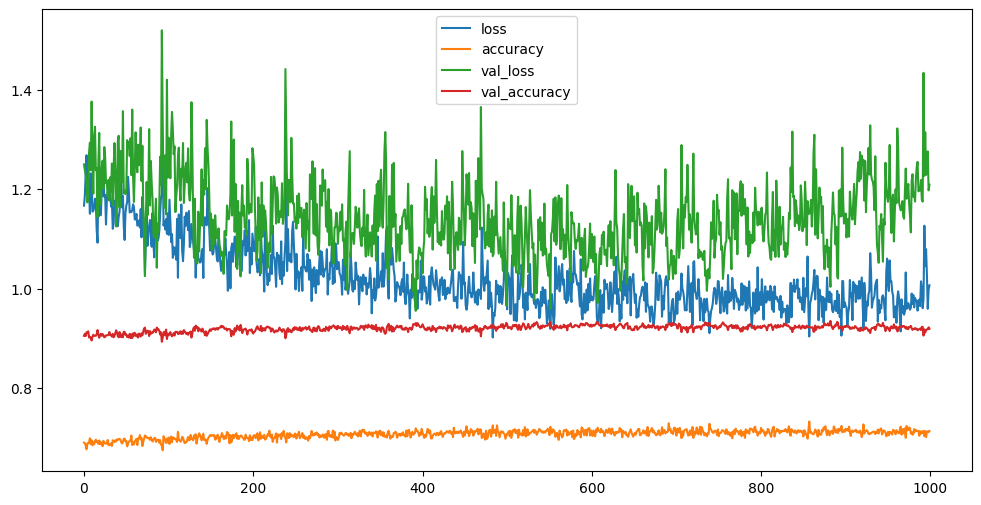

In [60]:
plotcurve(history)

In [61]:
model.save("drive/MyDrive/models/music_genre.h5")

In [62]:
json.dump(labels,open("labels.json","w"))

In [77]:
import librosa
import numpy as np

def extract_features(audio_path, sr=22050):
    """
    Extract features from an audio file to match the training data.
    :param audio_path: Path to the audio file.
    :param sr: Sample rate for reading the audio.
    :return: Feature array.
    """
    y, sr = librosa.load(audio_path, sr=sr)

    # Extract features
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft)
    chroma_stft_var = np.var(chroma_stft)

    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_var = np.var(rms)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_var = np.var(spectral_centroid)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_var = np.var(spectral_bandwidth)

    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_var = np.var(rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    zero_crossing_rate_var = np.var(zero_crossing_rate)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_var = np.var(mfcc, axis=1)

    # Additional features
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_mean = np.mean(mel_spectrogram)
    mel_spectrogram_var = np.var(mel_spectrogram)

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = np.mean(tonnetz, axis=1)
    tonnetz_var = np.var(tonnetz, axis=1)

    # Combine all features into a single array
    features = np.hstack([
        chroma_stft_mean, chroma_stft_var,
        rms_mean, rms_var,
        spectral_centroid_mean, spectral_centroid_var,
        spectral_bandwidth_mean, spectral_bandwidth_var,
        rolloff_mean, rolloff_var,
        zero_crossing_rate_mean, zero_crossing_rate_var,
        mfcc_mean, mfcc_var[:12],
        mel_spectrogram_mean, mel_spectrogram_var,
        tonnetz_mean, tonnetz_var
    ])

    return features

def predict_genre(audio_path):
    """
    Predict the genre of an audio file.
    :param audio_path: Path to the audio file.
    :return: Predicted genre.
    """
    # Extract features
    features = extract_features(audio_path)

    # Scale features
    features = scale.transform([features])

    # Make prediction
    prediction = model.predict(features)
    predicted_label = np.argmax(prediction, axis=1)[0]

    # Get the corresponding genre name
    genre = labels[predicted_label]
    return genre

audio_path = '/content/Data/genres_original/reggae/reggae.00006.wav'
genre = predict_genre(audio_path)
print(f"The predicted genre is: {genre}")


1/1 [==============================] - 0s 29ms/step
The predicted genre is: hiphop


In [78]:
import pandas as pd
import numpy as np
import librosa
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

In [80]:


# Load the feature dataset
df1 = pd.read_csv("/content/Data/features_3_sec.csv")

# Drop the filename column
df1 = df1.drop(columns=["filename"])

In [84]:
# Define function to extract features
def extract_features(audio_path, sr=22050):
    """
    Extract features from an audio file to match the training data.
    :param audio_path: Path to the audio file.
    :param sr: Sample rate for reading the audio.
    :return: Feature array.
    """
    try:
        y, sr = librosa.load(audio_path, sr=sr)
    except FileNotFoundError:
        # Handle missing file gracefully
        print(f"File not found: {audio_path}")
        return np.zeros(193)  # Return zeros as dummy features

    # Extract features (remaining code remains the same)
    chroma_stft = librosa.feature.chroma_stft(y=y, sr=sr)
    chroma_stft_mean = np.mean(chroma_stft)
    chroma_stft_var = np.var(chroma_stft)

    rms = librosa.feature.rms(y=y)
    rms_mean = np.mean(rms)
    rms_var = np.var(rms)

    spectral_centroid = librosa.feature.spectral_centroid(y=y, sr=sr)
    spectral_centroid_mean = np.mean(spectral_centroid)
    spectral_centroid_var = np.var(spectral_centroid)

    spectral_bandwidth = librosa.feature.spectral_bandwidth(y=y, sr=sr)
    spectral_bandwidth_mean = np.mean(spectral_bandwidth)
    spectral_bandwidth_var = np.var(spectral_bandwidth)

    rolloff = librosa.feature.spectral_rolloff(y=y, sr=sr)
    rolloff_mean = np.mean(rolloff)
    rolloff_var = np.var(rolloff)

    zero_crossing_rate = librosa.feature.zero_crossing_rate(y)
    zero_crossing_rate_mean = np.mean(zero_crossing_rate)
    zero_crossing_rate_var = np.var(zero_crossing_rate)

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20)
    mfcc_mean = np.mean(mfcc, axis=1)
    mfcc_var = np.var(mfcc, axis=1)

    # Additional features
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr)
    mel_spectrogram_mean = np.mean(mel_spectrogram)
    mel_spectrogram_var = np.var(mel_spectrogram)

    tonnetz = librosa.feature.tonnetz(y=librosa.effects.harmonic(y), sr=sr)
    tonnetz_mean = np.mean(tonnetz, axis=1)
    tonnetz_var = np.var(tonnetz, axis=1)

    # Combine all features into a single array
    features = np.hstack([
        chroma_stft_mean, chroma_stft_var,
        rms_mean, rms_var,
        spectral_centroid_mean, spectral_centroid_var,
        spectral_bandwidth_mean, spectral_bandwidth_var,
        rolloff_mean, rolloff_var,
        zero_crossing_rate_mean, zero_crossing_rate_var,
        mfcc_mean, mfcc_var[:12],
        mel_spectrogram_mean, mel_spectrogram_var,
        tonnetz_mean, tonnetz_var
    ])

    return features

In [87]:
audio_paths = "/content/Data/genres_original/" + df1["label"] + "/" + df1["label"] + "." + df1.index.astype(str).str.zfill(5) + ".wav"

# Create a new column for features
df1["features"] = [np.zeros(193) for _ in range(len(df1))]  # Initialize with zeros

# Populate the "features" column with extracted features
for i, audio_path in tqdm(enumerate(audio_paths), total=len(df1)):
    df1["features"].iloc[i] = extract_features(audio_path)

  0%|          | 0/9990 [00:00<?, ?it/s]<ipython-input-87-9af9f3bf2fa8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["features"].iloc[i] = extract_features(audio_path)
  0%|          | 1/9990 [00:03<9:06:48,  3.28s/it]<ipython-input-87-9af9f3bf2fa8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df1["features"].iloc[i] = extract_features(audio_path)
  0%|          | 2/9990 [00:05<7:14:54,  2.61s/it]<ipython-input-87-9af9f3bf2fa8>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user

KeyboardInterrupt: 

In [ ]:
# Separate features (X) and labels (y)
X = np.vstack(df1["features"])
y = df1["label"]

# Encode labels
encoder = LabelEncoder()
y = encoder.fit_transform(y)

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.33, random_state=42)


In [ ]:

# Define classifiers
classifiers = {
    "Naive Bayes": GaussianNB(),
    "Stochastic Gradient Descent": SGDClassifier(max_iter=5000, random_state=0),
    "KNN": KNeighborsClassifier(n_neighbors=19),
    "Decision Trees": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=1000, max_depth=10, random_state=0),
    "Support Vector Machine": SVC(decision_function_shape="ovo"),
    "Logistic Regression": LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial'),
    "Neural Nets": MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5000, 10), random_state=1),
    "Cross Gradient Booster": XGBClassifier(n_estimators=1000, learning_rate=0.05),
    "Cross Gradient Booster (Random Forest)": XGBClassifier(objective='multi:softmax'),
}

# Train and evaluate classifiers
for name, clf in classifiers.items():
    # Train the classifier
    clf.fit(X_train, y_train)

    # Predict genre for the test set
    y_pred = clf.predict(X_test)

    # Evaluate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy}")

    # Generate confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="BuPu", xticklabels=encoder.classes_, yticklabels=encoder.classes_)
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.title(f"{name} Confusion Matrix")
    plt.show()

    # Classification report
    print(f"Classification Report for {name}:")
    print(classification_report(y_test, y_pred, target_names=encoder.classes_))
